# LSTM Model
Training a LSTM (long short term memory) model to forecast time series sequence of stock closing price  
Using 5 timesteps to forecast 1 forward timestep 

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf


Upload closing price data

In [2]:
df = pd.read_csv('fb_rsi.csv')
df['date'] = pd.to_datetime(df['date'])

Convert pandas object to numpy array  

In [3]:
close = np.array(df['close'])
date = np.array(df['date'])
print(len(close))

160679


There are 160,679 timesteps, splitting 100,000 for training and the rest for testing  

In [4]:
split = 100000
date_train = date[:split] #Training split
x_train = close[:split]
date_val = date[split:] #Testing split
x_val = close[split:]

#Variables for the windowing function below
window_size = 5 #Number of timestep
batch_size = 250 #Number of sequence to be loaded into the model, depends to GPU memory
shuffle_buffer_size = 10000 #Instead for shuffling the entire 10,000 training data, shuffle 10,000 at a time

Windowing function to split the sequence into to features and labels  
Sequence is split into windows of 5 timesteps as the feature and the next timestep as the label

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# LSTM Model
Combining convolutional layers with LSTM layers for the complete model

In [6]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                            strides=1, padding='causal',
                            activation='relu', input_shape=[None, 1]), #1D convolution layer
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*500)
]) #Output is between 0-1, lambda layer to multiple output to match stock prices (Multiplication factor dependent on stock peak price)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae']) #Optimizing for MAE(mean absolute error)

Training model for 600 epochs  
Average 7 seconds per epoch, training time was around 1 hour 10 minutes

In [7]:
history = model.fit(train_set, epochs=600)

6
Epoch 399/600
400/400 [==============================] - 8s 19ms/step - loss: 1.5849 - mae: 2.0633
Epoch 400/600
400/400 [==============================] - 8s 19ms/step - loss: 1.7061 - mae: 2.1753
Epoch 401/600
400/400 [==============================] - 8s 19ms/step - loss: 1.3381 - mae: 1.7994
Epoch 402/600
400/400 [==============================] - 8s 19ms/step - loss: 1.5575 - mae: 2.0218
Epoch 403/600
400/400 [==============================] - 8s 19ms/step - loss: 1.5579 - mae: 2.0143
Epoch 404/600
400/400 [==============================] - 8s 19ms/step - loss: 1.6738 - mae: 2.1568
Epoch 405/600
400/400 [==============================] - 8s 19ms/step - loss: 1.6589 - mae: 2.1397
Epoch 406/600
400/400 [==============================] - 8s 19ms/step - loss: 1.6263 - mae: 2.0867
Epoch 407/600
400/400 [==============================] - 8s 19ms/step - loss: 1.5948 - mae: 2.0709
Epoch 408/600
400/400 [==============================] - 8s 19ms/step - loss: 1.1096 - mae: 1.5535
Epoch 40

In [ ]:
Plotting MAE and loss against epochs

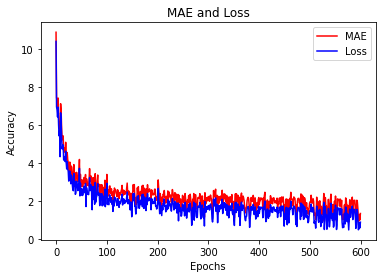

In [8]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.show()

Zooming into the last 100 epochs, although there are fluctuations, MAE and losses are still decreasing  
Model can be trained longer for higher accuracy

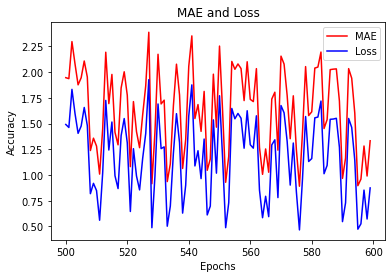

In [9]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs[-100:], mae[-100:], 'r')
plt.plot(epochs[-100:], loss[-100:], 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.show()

Saving the model

In [10]:
model.save('lstm.h5')

Function for forecasting of test data  
Similar to training, forecasting uses windows of 5 timesteps to forecast forward timestep

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(250).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Forecasting testing data

In [12]:
forecast = model_forecast(model, close[..., np.newaxis], window_size)
forecast = forecast[split - window_size:-1, -1, 0]

# Visualizing forecasted time series
Forecasted series looks similar to the actual stock, however the model was not able to match the peaks of the closing prices

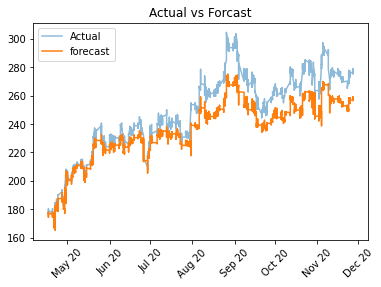

In [13]:
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b %y')

plt.plot(date_val, x_val, alpha=0.5)
plt.plot(date_val, forecast)

x = plt.gca()
x.xaxis.set_major_locator(locator)
x.xaxis.set_major_formatter(fmt)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xticks(rotation=45)
plt.show()

# Conclusion
Model performed well in forecasting unseen series, although the peaks were not as high the movement of the series has been captured by the model  
Model could be optimised by tuning the hyperparameter, adjusting the batch size and learning rate to smooth out the losses during training  
Increasing the number of training epochs could improve the model, as the MAE were still decreasing at 600 epochs  

## Further Optimizing the Model
Model could be improved by training with updated series data, as the model did not match the actual series after 2 months  
Model would have to be constantly retrained to ensure high accuracy